In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Dense, Activation, Dropout
from tensorflow.contrib.keras.python.keras.preprocessing import text, sequence
from tensorflow.contrib.keras.python.keras import utils

from collections import Counter

# This code was tested with TensorFlow v1.3
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.3.0


In [3]:
# The CSV was generated from this query: https://bigquery.cloud.google.com/savedquery/513927984416:c494494324be4a80b1fc55f613abb39c
# The data is also publicly available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv

data = pd.read_csv("https://storage.googleapis.com/vijay-public/text_classification/results-1000.csv")
NUM_ROWS = data.shape[0]
print("Loaded {} rows".format(NUM_ROWS))

Loaded 1000 rows


In [4]:
#Preview Data
data.head()

,post,tags
0,i have table of 8x8 i want to show images or v...,java|html|sql|oracle|jsp
1,putting the comment on a fb page i am using j...,javascript|facebook-graph-api|facebook-javascr...
2,multiple transactions in hibernate is there a...,java|hibernate
3,receiving fake path while uploading whenever ...,javascript|html|file-upload
4,replace the visual studio find results i m wa...,c#|.net|visual-studio-2010|visual-studio|visua...


In [5]:
#Generate list of N most common labels
NUM_CLASSES = 5
labels_list = []

counts = Counter('|'.join(data['tags'].tolist()).split('|'))
classes = counts.most_common(NUM_CLASSES)

for i in range(0,NUM_CLASSES):
    labels_list.append(classes[i][0])
    
print ("{} most common classes:".format(NUM_CLASSES))
classes

5 most common classes:


[('javascript', 376),
 ('java', 334),
 ('jquery', 133),
 ('c#', 100),
 ('html', 82)]

In [6]:
#utility functions to extract classes and translate between 
#human friendly (string) labels and machine friendly (array) labels

#labels_list: A list of the valid classes
#tags: A list of tags for a post
#returns an ndarray with ones for the active classes
def labels_to_array(tags,labels_list=labels_list):
    array = np.zeros(len(labels_list),dtype=np.int8)
    tags = tags.split('|') #split tags from pipe separated string into list
    for tag in tags:
        try:
            array[labels_list.index(tag)] = 1
        except ValueError: 
            None
    return array

#translate machine readable array back to human labels
def array_to_labels(array, labels_list=labels_list, threshold = 1):
    labels = []
    i=0
    for flag in array:
        if flag >= threshold: 
            labels.append(labels_list[i])
        i=i+1
    return labels

In [7]:
#test utility functions
print(data['tags'][4])
array = labels_to_array(data['tags'][4])
print(array)
array_to_labels(array)

c#|.net|visual-studio-2010|visual-studio|visual-studio-addins
[0 0 0 1 0]


['c#']

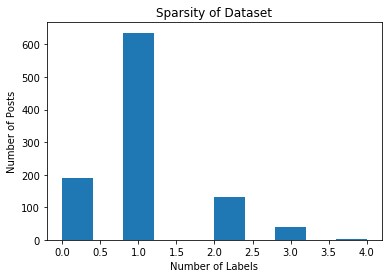

In [8]:
#Find label density
label_counts = np.zeros(NUM_ROWS)
for i in range(len(label_counts)):
    label_counts[i] = labels_to_array(data['tags'][i]).sum()
    
plt.xlabel('Number of Labels')
plt.ylabel('Number of Posts')
plt.title('Sparsity of Dataset')
plt.hist(label_counts)
plt.show()

In [9]:
# Split data into train and test
train_size = int(len(data) * .8)
test_size = len(data)-train_size
print ("Train size: %d" % train_size)
print ("Test size: %d" % test_size)

Train size: 800
Test size: 200


In [10]:
train_posts = data['post'][:train_size]
train_tags = data['tags'][:train_size]

test_posts = data['post'][train_size:]
test_tags = data['tags'][train_size:]

In [11]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [12]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [13]:
# generate multi-label arrays
y_train = np.zeros([train_size,NUM_CLASSES])
for i in range(0,train_size):
    y_train[i] = labels_to_array(data['tags'][i])

y_test = np.zeros([test_size,NUM_CLASSES])
for i in range(0,test_size):
    y_test[i] = labels_to_array(data['tags'][i+train_size-1])
y_test[0]

array([ 1.,  0.,  0.,  1.,  0.])

In [14]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (800, 1000)
x_test shape: (200, 1000)
y_train shape: (800, 5)
y_test shape: (200, 5)


In [15]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 2

In [16]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('sigmoid')) #changed from softmax

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) #changed from categorical_crossentropy

In [17]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 720 samples, validate on 80 samples
Epoch 1/2
720/720 [==============================] - 0s - loss: 0.4887 - acc: 0.7903 - val_loss: 0.3751 - val_acc: 0.8725
Epoch 2/2
720/720 [==============================] - 0s - loss: 0.3104 - acc: 0.8936 - val_loss: 0.2944 - val_acc: 0.8900


In [18]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

 32/200 [===>..........................] - ETA: 0sTest score: 0.595152249336
Test accuracy: 0.765000019073


In [19]:
# Here's how to generate a prediction on individual examples
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    #print(prediction[0])
    #print(y_test[i])
    predicted_label = array_to_labels(prediction[0],threshold=.5)
    print(test_posts.iloc[i][:200], "...")
    print('Actual label:' + '|'.join(array_to_labels(y_test[i])))
    print("Predicted label: " + '|'.join(predicted_label) + '\n')  

update single record with an array of results  a query leads to a list of results (@invoice_results - - also the name of the controller action) with two specific columns in the view (formatting remove ...
Actual label:javascript|c#
Predicted label: javascript

jquery and mouseevents  i have a question regarding mouse events in the jquery library. i have a simple javascript function as following:   <pre><code>$(function() {     var xpos;     var ypos;     $( ...
Actual label:
Predicted label: javascript

drag and drop using raphael.js has laggy performance with more than 10 draggable elements  i m making a simple html5 app  that will be wrapped to be used on android  ios and web browsers. in my app i  ...
Actual label:javascript|jquery|html
Predicted label: javascript|jquery

event logging in asp.net  i am using vs2005 c# .net 2.0 and sql server 2005.    are there any websites that provide step by step instructions to implement event logging for my web application     <str ...
Actual la

### Package for ML Engine

In [20]:
%%bash
mkdir trainer
touch trainer/__init__.py

mkdir: trainer: File exists


In [206]:
%%writefile trainer/task.py

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
import argparse
import json
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Dense, Activation, Dropout
from tensorflow.contrib.keras.python.keras.preprocessing import text, sequence
from tensorflow.contrib.keras.python.keras import utils

from collections import Counter

print("You have TensorFlow version", tf.__version__)

# Hyperparamters for tuning
parser = argparse.ArgumentParser()
# Input Arguments
parser.add_argument(
  '--train_batch_size',
  help='Batch size for training steps',
  type=int,
  default=32
)
parser.add_argument(
  '--epochs',
  help='Number of epochs to train for',
  type=int,
  default=2
)
parser.add_argument(
      '--output_dir',
      help='GCS location to write checkpoints and export models',
      required=True
)
parser.add_argument(
        '--job-dir',
        help='this model ignores this field, but it is required by gcloud',
        default='junk'
)
args = parser.parse_args()

#Download CSV
data = pd.read_csv("https://storage.googleapis.com/vijay-public/text_classification/results-1000.csv")
NUM_ROWS = data.shape[0]
print("Loaded {} rows".format(NUM_ROWS))

#Generate list of N most common labels
NUM_CLASSES = 5
labels_list = []

counts = Counter('|'.join(data['tags'].tolist()).split('|'))
classes = counts.most_common(NUM_CLASSES)

for i in range(0,NUM_CLASSES):
    labels_list.append(classes[i][0])
    
print ("{} most common classes:".format(NUM_CLASSES))
print(classes)

#utility functions to extract classes and translate between 
#human friendly (string) labels and machine friendly (array) labels

#labels_list: A list of the valid classes
#tags: A list of tags for a post
#returns an ndarray with ones for the active classes
def labels_to_array(tags,labels_list=labels_list):
    array = np.zeros(len(labels_list),dtype=np.int8)
    tags = tags.split('|') #split tags from pipe separated string into list
    for tag in tags:
        try:
            array[labels_list.index(tag)] = 1
        except ValueError: 
            None
    return array

#translate machine readable array back to human labels
def array_to_labels(array, labels_list=labels_list, threshold = 1):
    labels = []
    i=0
    for flag in array:
        if flag >= threshold: 
            labels.append(labels_list[i])
        i=i+1
    return labels

# Split data into train and test
train_size = int(len(data) * .8)
test_size = len(data)-train_size
print ("Train size: %d" % train_size)
print ("Test size: %d" % test_size)

train_posts = data['post'][:train_size]
train_tags = data['tags'][:train_size]

test_posts = data['post'][train_size:]
test_tags = data['tags'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

# generate multi-label arrays
y_train = np.zeros([train_size,NUM_CLASSES])
for i in range(0,train_size):
    y_train[i] = labels_to_array(data['tags'][i])

y_test = np.zeros([test_size,NUM_CLASSES])
for i in range(0,test_size):
    y_test[i] = labels_to_array(data['tags'][i+train_size-1])
y_test[0]

# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


#Set hyperparameters
batch_size = args.train_batch_size
epochs = args.epochs


# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('sigmoid')) #changed from softmax

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) #changed from categorical_crossentropy

# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting


#Enable Tensorboard logging
Tensorboard = keras.callbacks.TensorBoard(log_dir=args.output_dir + "/tensorboard")

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[Tensorboard]) #callback for Tensorboard

# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])


# Here's how to generate a prediction on individual examples
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    #print(prediction[0])
    #print(y_test[i])
    predicted_label = array_to_labels(prediction[0],threshold=.5)
    print(test_posts.iloc[i][:200], "...")
    print('Actual label:' + '|'.join(array_to_labels(y_test[i])))
    print("Predicted label: " + '|'.join(predicted_label) + '\n') 

Overwriting trainer/task.py


In [207]:
%%bash
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=trainer \
   -- \
   --output_dir='./output'

You have TensorFlow version 1.3.0
Loaded 1000 rows
5 most common classes:
[('javascript', 376), ('java', 334), ('jquery', 133), ('c#', 100), ('html', 82)]
Train size: 800
Test size: 200
x_train shape: (800, 1000)
x_test shape: (200, 1000)
y_train shape: (800, 5)
y_test shape: (200, 5)
Train on 720 samples, validate on 80 samples
Epoch 1/2
720/720 [==============================] - 0s - loss: 0.4753 - acc: 0.8058 - val_loss: 0.3592 - val_acc: 0.8700
Epoch 2/2
 32/200 [===>..........................] - ETA: 0sTest score: 0.611883540154
update single record with an array of results  a query leads to a list of results (@invoice_results - - also the name of the controller action) with two specific columns in the view (formatting remove ...
Actual label:javascript|c#
Predicted label: javascript

jquery and mouseevents  i have a question regarding mouse events in the jquery library. i have a simple javascript function as following:   <pre><code>$(function() {     var xpos;     var ypos;     $

2017-11-02 19:58:33.355251: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-11-02 19:58:33.355267: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-11-02 19:58:33.355271: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-11-02 19:58:33.355276: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine and could speed up CPU computations.


In [23]:
GCS_BUCKET = 'gs://vijays-sandbox-ml' #CHANGE THIS TO YOUR BUCKET
PROJECT = 'vijays-sandbox' #CHANGE THIS TO YOUR PROJECT ID
REGION = 'us-central1' #OPTIONALLY CHANGE THIS

In [24]:
import os
os.environ['GCS_BUCKET'] = GCS_BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [202]:
%%writefile config.yaml
trainingInput:
  hyperparameters:
    goal: MAXIMIZE
    hyperparameterMetricTag: val_acc
    maxTrials: 4
    maxParallelTrials: 1
    params:
    - parameterName: train_batch_size
      type: INTEGER
      minValue: 1
      maxValue: 1000
      scaleType: UNIT_LINEAR_SCALE

Overwriting config.yaml


In [203]:
%%bash
JOBNAME=text_classification_$(date -u +%y%m%d_%H%M%S)

gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --runtime-version=1.2 \
   --module-name=trainer.task \
   --package-path=./trainer \
   --job-dir=$GCS_BUCKET/$JOBNAME/ \
   --config config.yaml \
   -- \
   --output_dir=$GCS_BUCKET/$JOBNAME/output

jobId: text_classification_171102_234927
state: QUEUED


Job [text_classification_171102_234927] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe text_classification_171102_234927

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs text_classification_171102_234927
